In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from progressbar import ProgressBar


from os import listdir
from os.path import isfile, join
import datetime
import calendar


%matplotlib inline

#custom functions
def NSC(y_pred,y_true):
    """
    Nash-Sutcliffe Coefficient
    """
    return 1 - sum((y_pred-y_true)**2)/sum((y_true-np.mean(y_true))**2)

def corr(data1, data2):
    "data1 & data2 should be numpy arrays."
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()

#     corr = ((data1-mean1)*(data2-mean2)).mean()/(std1*std2)
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:

#This is the final dataset to make predictions on
p = Path('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Processed_Training_Data')
#dir_data = 'C:/Users/Ryan/Box/Dissertation/Paper1/Data/Model_Input_Data/Monthly/Input/FinalVars'

slc = {i.stem[0:3] : pd.read_excel(i) for i in p.glob('**/*.xlsx')}

#rename the gpcd column
for i in slc:
    slc[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slc[i]=slc[i].set_index('Year')
snow=pd.read_excel('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Alta_LCC_snow.xlsx')
snow=snow.set_index('Year')



In [4]:
#Create training and testing data, use most recent low, average, and high water years
slc_train=copy.deepcopy(slc)
slc_test=copy.deepcopy(slc)

#2008 is a high year
#2011 and 2017 are average years
#2014 and 2016 are below average years
#2015 is a very  low year

IN_WY_Months = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct']
Prior_YR_WY_Months = ['Nov', 'Dec']
testWYyrs = [2008,2015,2017]
#testPrioWYyrs = [2007,2014,2016]


for i in slc:
    #Select the training/testing dataframes
    slc_train[i]=slc_train[i][~slc_train[i].index.isin(testWYyrs)]
    slc_test[i]=slc_test[i][slc_test[i].index.isin(testWYyrs)]
   
    


In [5]:
#Create training and testing data
#slc_train=copy.deepcopy(slc)
#slc_test=copy.deepcopy(slc)

#Train_yrs= 26
#

#for i in slc:
    #Select the training/testing dataframes
 #   slc_train[i]=slc_train[i][:Train_yrs]
  #  slc_test[i]=slc_test[i][Train_yrs:]

In [6]:
    

#Determine the indoor mean to subtract from outdoor
I_mean_train=(slc_train['Jan']['Obs_gpcd']+
              slc_train['Feb']['Obs_gpcd']+
              slc_train['Mar']['Obs_gpcd']+
              slc_train['Nov']['Obs_gpcd']+
             slc_train['Dec']['Obs_gpcd'])/5
I_mean_test=(slc_test['Jan']['Obs_gpcd']+
             slc_test['Feb']['Obs_gpcd']+
             slc_test['Mar']['Obs_gpcd']+
             slc_test['Nov']['Obs_gpcd']+
             slc_test['Dec']['Obs_gpcd'])/5
#This uses total demand for irrigation seasons
#I_mean_train=np.zeros(23)
#I_mean_test=np.zeros(10)

for i in slc_train:
    slc_train[i]['Iave']=I_mean_train
    #for now include testing years
    slc_test[i]['Iave']=I_mean_test

IrrSeason= ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
colrem=['Iave', 'Obs_gpcd']
#set the target gpcd to indoor for indoor and total-indoor for outdoor
#change to indoor to separate outdoor demands from total
for i in Indoor:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']
    slc_test[i]= slc_test[i].drop(columns=colrem)
    

#Establish outdoor conservation thresholds
O_cons = 0.25
time = 20


for i in IrrSeason:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']-slc_train[i]['Iave']
    slc_train[i].loc[slc_train[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #add in snow info
    slc_train[i]=pd.concat([slc_train[i], snow], axis=1, join="inner")
    
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]=pd.concat([slc_test[i], snow], axis=1, join="inner")
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']-slc_test[i]['Iave']
    slc_test[i].loc[slc_test[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #create monthly historical mean and conservation trends
    Out_mean = np.mean(slc_train[i]['Target_gpcd'].loc[2000:])
    goal = (1-O_cons)*Out_mean
    O_cons_rate = (Out_mean -goal)/time
    


    slc_train[i]['cons_goal'] = Out_mean- ((slc_train[i].index-2000)*O_cons_rate)
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Out_mean
    
    t=slc_train[i]['Target_gpcd'].copy()
    c=slc_train[i]['cons_goal'].copy()
    slc_train[i] = slc_train[i].drop(columns=['Target_gpcd', 'cons_goal'])
    slc_train[i]['Target_gpcd'] = t
    slc_train[i]['cons_goal'] = c
    
    slc_test[i]['cons_goal'] = Out_mean - ((slc_test[i].index-2000)*O_cons_rate) 
    
 
    
    
    slc_test[i]= slc_test[i].drop(columns=colrem)

    
#Determine the historical indoor mean to apply conservation strategies too
Indmean = np.mean(slc_train['Jan']['Target_gpcd'].loc[2000:]+
                  slc_train['Feb']['Target_gpcd'].loc[2000:]+
                  slc_train['Mar']['Target_gpcd'].loc[2000:]+
                  slc_train['Nov']['Target_gpcd'].loc[2000:]+
                 slc_train['Dec']['Target_gpcd'].loc[2000:])/5
'''Per UDWR 2001, Utah's Water Resources: Planning for the future, the govenor ordered a
25% reduction in water use by 2025
'''
cons = 0.28

goal = (1-cons)*Indmean

time = 20

cons_rate = (Indmean -goal)/time

#print(cons_rate , goal)

#create feature called cons_goal!
for i in Indoor:
    slc_test[i]['cons_goal'] = Indmean-((slc_test[i].index-2000)*cons_rate) 
    slc_train[i]['cons_goal'] = Indmean-((slc_train[i].index-2000)*cons_rate) 
    
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Indmean
    
    
Cons_mean_test=(slc_test['Jan']['cons_goal']+
                slc_test['Feb']['cons_goal']+
                slc_test['Mar']['cons_goal']+
                slc_test['Nov']['cons_goal']+
                slc_test['Dec']['cons_goal'])/5

#split training and testing data into features and targets
slc_train_target=copy.deepcopy(slc_train)
slc_train_features=copy.deepcopy(slc_train)

slc_test_target=copy.deepcopy(slc_test)
slc_test_features=copy.deepcopy(slc_test)


target=['Target_gpcd','Housing']
for i in slc_train_target:
    slc_train_target[i]=slc_train_target[i]['Target_gpcd']
    #for now include testing years
    slc_test_target[i]=slc_test_target[i]['Target_gpcd']


    slc_train_features[i]= slc_train_features[i].drop(columns=target)
    #for now include testing years
    slc_test_features[i]= slc_test_features[i].drop(columns=target)
    
#need to remove year from the list to run plots below
for i in slc_train:
    slc_train[i]=slc_train[i].drop(columns=['Housing',  'Population', 'PopulationDensity'])


In [7]:
#Use features from MLR 

Apr = ['Val_Apr_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_precip_mm', 'LitCotCrk_AcFt_WR_Apr',
       'LitCotCrk_AcFt_WR_Mar', 'Target_gpcd']
May = ['Val_May_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C', 'Target_gpcd']
Jun = ['Val_Jun_Monthly_precip_mm', 'Val_Apr_Monthly_mean_Day_temp_C', 'BigCotCrk_AcFt_WR_Jun', 
       'Val_May_Monthly_mean_Day_temp_C', 'CityCrk_AcFt_WR_May', 'BigCotCrk_AcFt_WR_May', 
       'Val_May_Monthly_precip_mm', 'Target_gpcd']
Jul = ['UrbPopulationDensity', 'Val_Jul_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C',
       'Val_May_Monthly_mean_Day_temp_C', 'Target_gpcd']
Aug = ['Val_Aug_Monthly_precip_mm', 'UrbPopulationDensity', 'LitCotCrk_AcFt_WR_Apr',
       'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 'LitCotCrk_AcFt_WR_Mar', 
       'Val_Apr_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C', 'Val_Jul_Monthly_mean_Day_temp_C', 
       'Val_Jun_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_precip_mm', 'BigCotCrk_AcFt_WR_May',
       'LitCotCrk_AcFt_WR_May', 'Target_gpcd']
Sep = ['Val_Sep_Monthly_precip_mm', 'Val_Sep_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 
       'Val_May_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_mean_Day_temp_C',
       'Val_Jul_Monthly_mean_Day_temp_C', 'Target_gpcd']
Oct = ['cons_goal','Target_gpcd']


#select these features for training and testing
slc_train['Apr'] = slc_train['Apr'][Apr]
slc_test['Apr'] = slc_test['Apr'][Apr]

slc_train['May'] = slc_train['May'][May]
slc_test['May'] = slc_test['May'][May]

slc_train['Jun'] = slc_train['Jun'][Jun]
slc_test['Jun'] = slc_test['Jun'][Jun]

slc_train['Jul'] = slc_train['Jul'][Jul]
slc_test['Jul'] = slc_test['Jul'][Jul]

slc_train['Aug'] = slc_train['Aug'][Aug]
slc_test['Aug'] = slc_test['Aug'][Aug]

slc_train['Sep'] = slc_train['Sep'][Sep]
slc_test['Sep'] = slc_test['Sep'][Sep]

slc_train['Oct'] = slc_train['Oct'][Oct]
slc_test['Oct'] = slc_test['Oct'][Oct]

In [8]:
def model_plots(PerfDF, month):
    
    plotmin = PerfDF[['y_pred', 'y_test']].min().min()
    plotmax = PerfDF[['y_pred', 'y_test']].max().max()
    
    plotmin_tot = PerfDF[['y_pred_tot', 'y_test_tot']].min().min()
    plotmax_tot = PerfDF[['y_pred_tot', 'y_test_tot']].max().max()
    
    
    fig, ax = plt.subplots(3,2, constrained_layout=True)
    fig.set_size_inches(9,10)

    ax[0,0].scatter(PerfDF['y_test'], PerfDF['y_pred'],color='blue', alpha=0.5)
    ax[0,0].set_ylabel('Predicted')
    ax[0,0].set_xlabel('Observed')
    ax[0,0].set_ylim(plotmin-5,plotmax+5)
    ax[0,0].set_xlim(plotmin-5,plotmax+5)
    ax[0,0].set_title('Outdoor Model Performance')
    ax[0,0].plot([plotmin,plotmax],[plotmin,plotmax], color='red', linestyle='--' )
    ax[0,0].spines['bottom'].set_color('black')
    ax[0,0].spines['left'].set_color('black')
    
    ax[0,1].scatter(PerfDF['y_test_tot'], PerfDF['y_pred_tot'],color='blue', alpha=0.5)
    ax[0,1].set_ylabel('Predicted')
    ax[0,1].set_xlabel('Observed')
    ax[0,1].set_ylim(plotmin_tot-5,plotmax_tot+5)
    ax[0,1].set_xlim(plotmin_tot-5,plotmax_tot+5)
    ax[0,1].set_title('Indoor and Outdoor \n Model Performance')
    ax[0,1].plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    ax[0,1].spines['bottom'].set_color('black')
    ax[0,1].spines['left'].set_color('black')

    
    
    
    gs = ax[1, 1].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()

    PerfDF['Error'] = (PerfDF['y_pred']-PerfDF['y_test'])
    axbig1 = fig.add_subplot(gs[1, :])
    axbig1.set_title(month+' Outdoor demand Timeline Evaluation')
    axbig1.axhline(y = 0 , color = 'black')
    #axbig1.bar(PerfDF.index, PerfDF['y_pred'], color='orange', label='Predicted')
    Error1 = axbig1.bar(PerfDF.index, PerfDF['Error'],color='blue', label='Prediction Error')
    axbig1.set_xlabel('Year')
    axbig1.set_ylabel('Error (GPCD)')
    axbig1.spines['bottom'].set_color('black')
    axbig1.spines['left'].set_color('black')
    gradientbars_sliced(Error1)
    
    
    gs2 = ax[2, 1].get_gridspec()
    # remove the underlying axes
    ax[2,0].remove()
    ax[2,1].remove()


    #create error value
    PerfDF['Error_tot'] = (PerfDF['y_pred_tot']-PerfDF['y_test_tot'])
    
    axbig2 = fig.add_subplot(gs2[2, :])
    axbig2.set_title(month+' Total Demand Error Timeline Evaluation')
    Error2 = axbig2.bar(PerfDF.index, PerfDF['Error_tot'], color='blue', label='Predicted')
    axbig2.axhline(y = 0 , color = 'black')
    #axbig2.bar(PerfDF.index, PerfDF['y_test_tot'],color='blue', label='Observed')
    axbig2.set_xlabel('Year')
    axbig2.set_ylabel('Error (GPCD)')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    gradientbars_sliced(Error2)
    
    fig.suptitle(month+ ' Evaluation', size = 16)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLP' + month + '_demand.pdf')    
    
    O_r2 = sklearn.metrics.r2_score(PerfDF['y_test'],PerfDF['y_pred'])
    O_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test'],PerfDF['y_pred'], squared = False)
    O_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test'],PerfDF['y_pred'])
    O_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test'],PerfDF['y_pred'])
    
    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    
    print('The outdoor Demand prediction RMSE is ', O_rmse)
    print('The outdoor Demand prediction R2 is ', O_r2)
    
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%')     
    
  
    #set DF up so that all months can be easily combined, basically year-month index

In [9]:
def Indoor_Demand_Model(df, month):
    #Make matching indoor demand model
    datetime_object = datetime.datetime.strptime(month, "%b")
    df[month]['month'] = datetime_object.month
    
    df[month]['Year']=df[month].index
    
     #set up dates so all months can be combined and sorted
    day=[]
    for index, row in df[month].iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    df[month]['Day']=day
    
  
    df[month]['Date'] = pd.to_datetime(df[month][['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    df[month]=df[month].drop(columns=['month', 'Day'])
    df[month]=df[month].reset_index(drop=True)
   
    
    colrem = slc_test[i].columns
    df[month]['y_pred'] =  df[month]['cons_goal']
    df[month]['y_test'] =  df[month]['Target_gpcd']
    df[month]['y_pred_tot'] =  df[month]['cons_goal']
    df[month]['y_test_tot'] =  df[month]['Target_gpcd']
       
    df[month] = df[month].set_index('Date')
    
    df[month] = df[month].drop(columns=colrem)
    
    return df

In [10]:
'''
The MLP model needs to take in normalized numpy arrays. The MLP Water Demand Model needs to:
1) take in all of the data (training and testing)
2) normalize that months training and testing inputs (0-1)
3) train and save the model, '_ReluDem_{val_loss:.8f}.h5'
4) predict on testing dataset
5) convert to original units
6) Deliver prediction datastat (with orginial testing data) to send to figure generator.
'''

def MLP_OutdoorDemandModel(df_train, df_test,month, checkpointfilename):
    
    traindf = df_train.copy()
    testdf = df_test.copy()
    
    #find the min of input data
    dfmin = traindf.append(testdf).copy()
    dfmin = list(dfmin.min())

    #normalize process A
    traindf = traindf-dfmin
    testdf = testdf-dfmin
      
    #find the min of input data
    dfmax = traindf.append(testdf).copy()
    dfmax = list(dfmax.max())

    #normalize process A
    traindf = traindf/dfmax
    testdf = testdf/dfmax
    
    #separate into training and testing features and targets
    features_tr = traindf.drop(columns =['Target_gpcd']).copy()
    features_val = testdf.drop(columns =['Target_gpcd']).copy()
    
    target_tr = traindf['Target_gpcd'].copy()
    target_val = testdf['Target_gpcd'].copy()
    
    #convert to numpy array for model
    features_tr = np.array(features_tr.to_numpy())
    features_val = np.array(features_val.to_numpy())
    
    target_tr_ = np.array(target_tr.to_numpy())
    target_val = np.array(target_val.to_numpy())
    
    #we want a y_test for later on too
    y_test = (target_val.copy()*dfmax[-1])+dfmin[-1]
   
    
    
    #Get the numpy shape for the model
    shape = features_tr.shape

    
    #now input the model
    
    #start_time = time.time()

    checkpoint_filepath = 'MLP_Models/'+str(month)+ '/'
    checkpoint_filename = checkpoint_filepath+checkpointfilename
    callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filename,
        monitor='val_loss',
        mode='min',
        save_best_only=True)


    input_1 = layers.Input(shape=(shape[1],))
    x = layers.Dense(128, activation="relu")(input_1)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=input_1,outputs=x)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4), metrics=['mae'])
    #print(model.summary())
    print(month, " is being trained and calibrated.")
    #training time for 50 epochs took 3601seconds, 60 mins, 500 epochs
    model = model.fit(features_tr, target_tr, epochs=500, batch_size=1,
                        validation_data=(features_val,target_val),shuffle=True,
                      callbacks=[callback], verbose=0)

    #load the model with highest performance
    bestmodel = [f for f in listdir(checkpoint_filepath) if isfile(join(checkpoint_filepath, f))]
    bestmodel.sort()
    bestmodel = checkpoint_filepath+bestmodel[0]
    model=load_model(bestmodel)
    
    #Make predictions on the validation data
    y_pred = model.predict(features_val)
    #make sure no negative values
   # y_pred = [0 if x < 0 else x for x in y_pred]
    
    #convert predictions to gpcd and place into OG dataframe
    y_pred = (y_pred*dfmax[-1])+dfmin[-1]
    shape = y_pred.shape
    y_pred = y_pred.reshape(shape[0])
    #measure the modeling performance of the MLP model
    O_r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    O_rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    print('Outdoor R2 is ', O_r2_test)
    print('Outdoor RMSE is ', O_rmse_test)
        
    #put df in same format as MLR model
    PerfDF=pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])

#Add indoor demands
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if month in Indoor:
        PerfDF['y_test']=PerfDF['y_test']
        PerfDF['y_pred']=PerfDF['y_pred']
    else:
        PerfDF['y_test_tot']=PerfDF['y_test']+list(I_mean_test)
        PerfDF['y_pred_tot']=PerfDF['y_pred']+list(Cons_mean_test)

    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'], PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'], PerfDF['y_pred_tot'], 
                                               squared = False)
  

    PerfDF['Year'] = list(slc_test['Jul'].index)
    PerfDF=PerfDF.set_index('Year')
   

    datetime_object = datetime.datetime.strptime(month, "%b")
    PerfDF['month'] = datetime_object.month
    PerfDF['Year']=PerfDF.index
   
    
    #set up dates so all months can be combined and sorted
    day=[]
    for index, row in PerfDF.iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    PerfDF['Day']=day
  
    PerfDF['Date'] = pd.to_datetime(PerfDF[['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    PerfDF=PerfDF.drop(columns=['Year', 'month', 'Day'])
    PerfDF=PerfDF.reset_index()
    
    model_plots(PerfDF, month)
    
    
    return PerfDF



In [11]:
#PerfDF = MLP_OutdoorDemandModel(slc_train['Apr'], slc_test['Apr'],'Apr', 'ReluDem_{val_loss:.8f}.h5')


In [12]:
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral')
    ax.axis([xmin, xmax, ymin, ymax])


In [16]:
#Make a function to put all of the predictions together
def Demand_Forecast(prediction_dictionary, pdict, df, pred, test, units, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
    months = np.arange(1,6,1)
    Low = list()
    Ave=list()
    High = list()
    for i in months:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
        
    Low.append('Drought')
    Ave.append('Average')
    High.append('Surplus')
    
    months2 = np.arange(7,13,1)
    for i in months2:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
    
    Conditions = High+Low+Ave

    #adjust date range to improve figure
    #FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot = FinalDF[[pred, test]].min().min()
    plotmax_tot = FinalDF[[pred, test]].max().max()

    fig, ax = plt.subplots(1,5, constrained_layout=True)
    fig.set_size_inches(12,4)

    gs2 = ax[0].get_gridspec()
    # remove the underlying axes
    ax[0].remove()
    ax[1].remove()
    ax[2].remove()
    axbig = fig.add_subplot(gs2[:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    axbig.plot(FinalDF[pred], color='orange', label= model+'Predicted')
    axbig.plot(FinalDF[test],color='blue', label='Observed')
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot-.9,plotmax_tot*1.2)
    axbig.set_ylabel('Demand ('+ units+')')
    axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i%12 != 5:
            tick.label1.set_visible(False)

    ax[3].remove()
    ax[4].remove()


    axbig2 = fig.add_subplot(gs2[3:])
    axbig2.scatter(FinalDF[test], FinalDF[pred],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units+')' )
    axbig2.set_xlabel('Observed (' + units+')')
    axbig2.set_ylim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.set_xlim(plotmin_tot*.95,plotmax_tot*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    #ax[2].set_aspect('equal', adjustable='box')

   
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLP' +str(plotname)+'.pdf')
    r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

    print('Total R2 is ', r2)
    print('Total MAE is ', MAE)
    print('Total RMSE is ', RMSE)
    print('Total MAPE is ', MAPE)
    
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    
    return FinalDF

Apr  is being trained and calibrated.
Outdoor R2 is  0.5937303166522887
Outdoor RMSE is  7.136751982304181


The outdoor Demand prediction RMSE is  7.136751982304181
The outdoor Demand prediction R2 is  0.5937303166522887
The Total Demand prediction RMSE is  12.898387879850468
The Total Demand prediction R2 is  0.36591391256584893
The Total Demand prediction MAE is  9.725359704707211
The Total Demand prediction MAPE is  0.06394925048253002 %
May  is being trained and calibrated.
Outdoor R2 is  0.6421361019957679
Outdoor RMSE is  18.340410522587963


The outdoor Demand prediction RMSE is  18.340410522587963
The outdoor Demand prediction R2 is  0.6421361019957679
The Total Demand prediction RMSE is  24.469164452473105
The Total Demand prediction R2 is  0.6954449078313416
The Total Demand prediction MAE is  18.59359277450169
The Total Demand prediction MAPE is  0.07331031030203554 %
Jun  is being trained and calibrated.
Outdoor R2 is  0.7037698465716781
Outdoor RMSE is  15.453846755583172


The outdoor Demand prediction RMSE is  15.453846755583172
The outdoor Demand prediction R2 is  0.7037698465716781
The Total Demand prediction RMSE is  26.6924380684419
The Total Demand prediction R2 is  0.15153665791766124
The Total Demand prediction MAE is  26.008916095753232
The Total Demand prediction MAPE is  0.0646337216287104 %
Jul  is being trained and calibrated.
Outdoor R2 is  0.08881442090794056
Outdoor RMSE is  34.8770180795522


The outdoor Demand prediction RMSE is  34.8770180795522
The outdoor Demand prediction R2 is  0.08881442090794056
The Total Demand prediction RMSE is  45.558475531944254
The Total Demand prediction R2 is  0.0656137934324208
The Total Demand prediction MAE is  44.88932443910257
The Total Demand prediction MAPE is  0.09522422195710811 %
Aug  is being trained and calibrated.
Outdoor R2 is  0.20881026074967468
Outdoor RMSE is  39.07940262776053


The outdoor Demand prediction RMSE is  39.07940262776053
The outdoor Demand prediction R2 is  0.20881026074967468
The Total Demand prediction RMSE is  42.35673206586278
The Total Demand prediction R2 is  0.46790554579600674
The Total Demand prediction MAE is  42.07823195500299
The Total Demand prediction MAPE is  0.10671687922495991 %
Sep  is being trained and calibrated.
Outdoor R2 is  0.7621385786438251
Outdoor RMSE is  13.459084829054108


The outdoor Demand prediction RMSE is  13.459084829054108
The outdoor Demand prediction R2 is  0.7621385786438251
The Total Demand prediction RMSE is  27.359354265706965
The Total Demand prediction R2 is  0.4232520472114184
The Total Demand prediction MAE is  18.087291746794886
The Total Demand prediction MAPE is  0.0519614094361071 %
Oct  is being trained and calibrated.
Outdoor R2 is  0.05795157194571121
Outdoor RMSE is  16.842878791418663


The outdoor Demand prediction RMSE is  16.842878791418663
The outdoor Demand prediction R2 is  0.05795157194571121
The Total Demand prediction RMSE is  16.75399148592276
The Total Demand prediction R2 is  0.4302415344651209
The Total Demand prediction MAE is  14.724250275722406
The Total Demand prediction MAPE is  0.07507922567012597 %
yes



<ipython-input-11-de83e5ce486e>:92: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLP' +str(plotname)+'.pdf')
<ipython-input-11-de83e5ce486e>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


Total R2 is  0.9590024871295585
Total MAE is  20.72183314673465
Total RMSE is  25.88379917103648
Total MAPE is  6.265183895913638


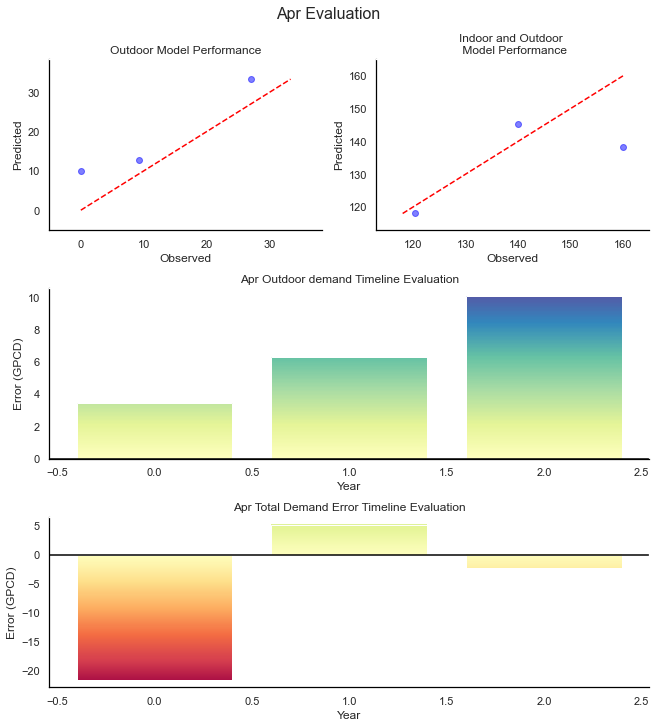

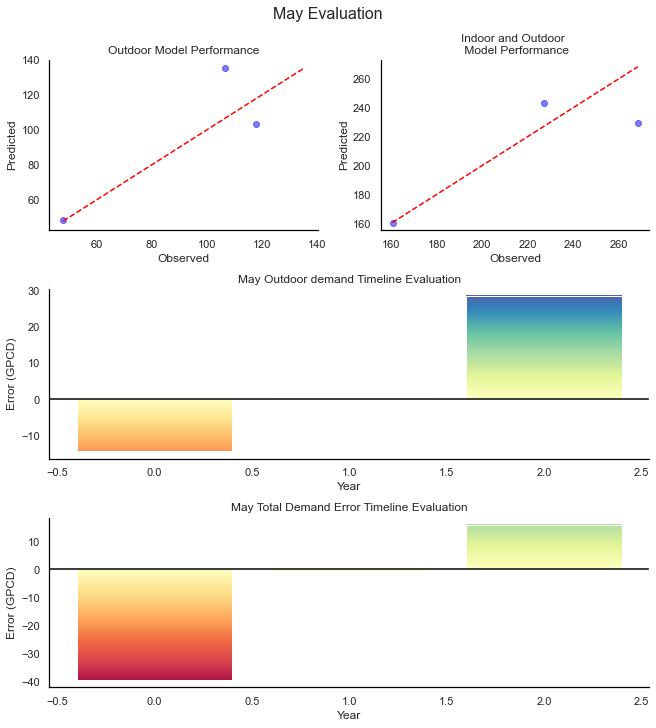

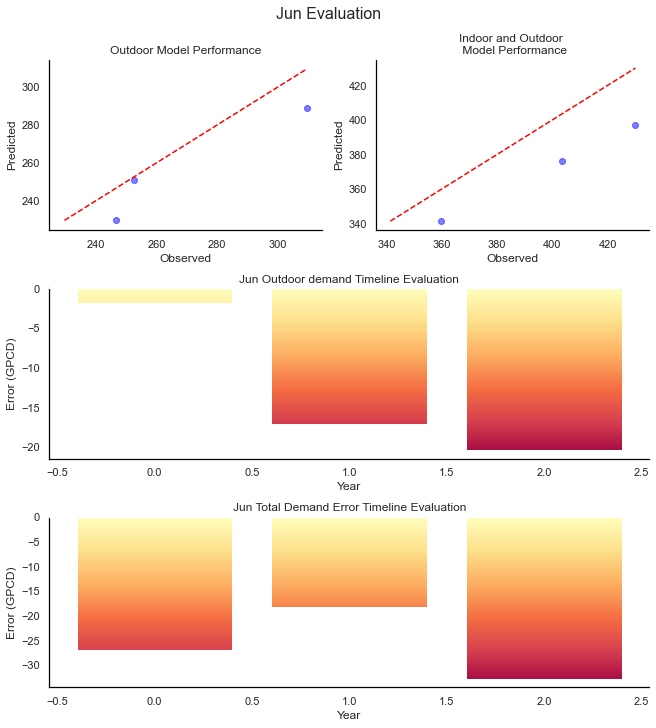

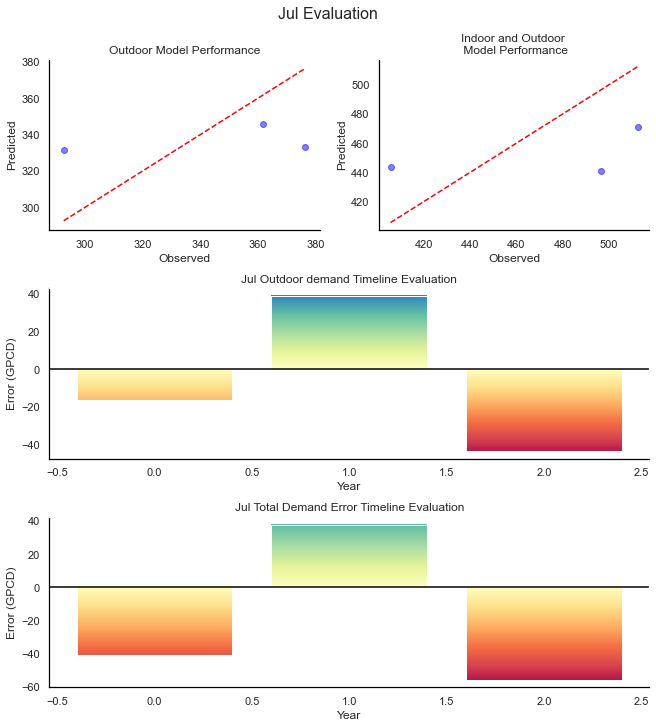

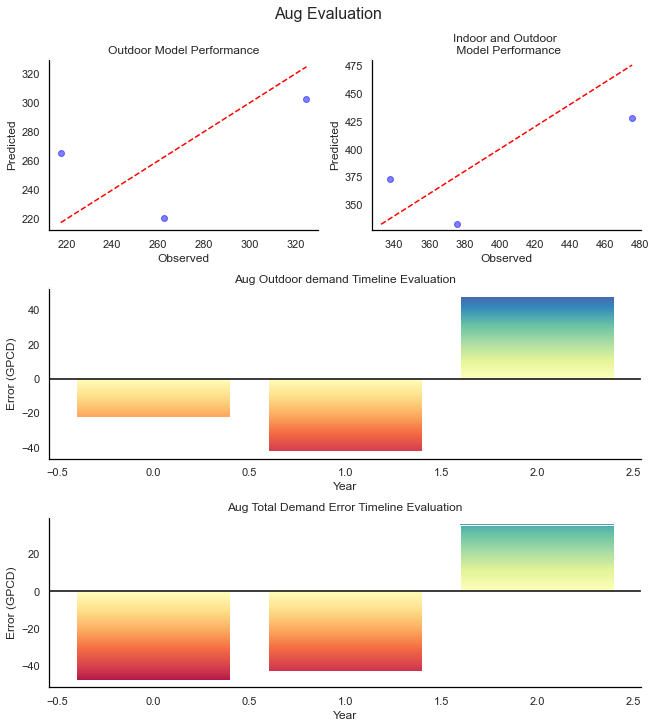

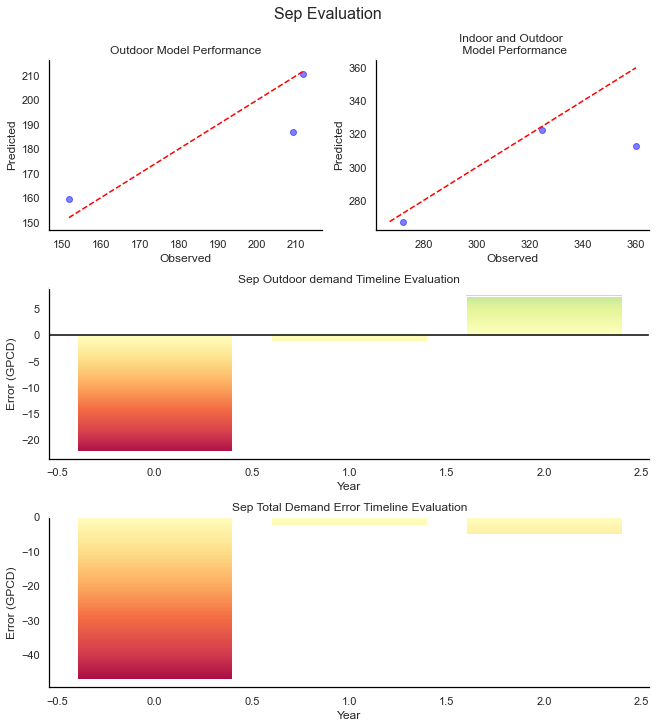

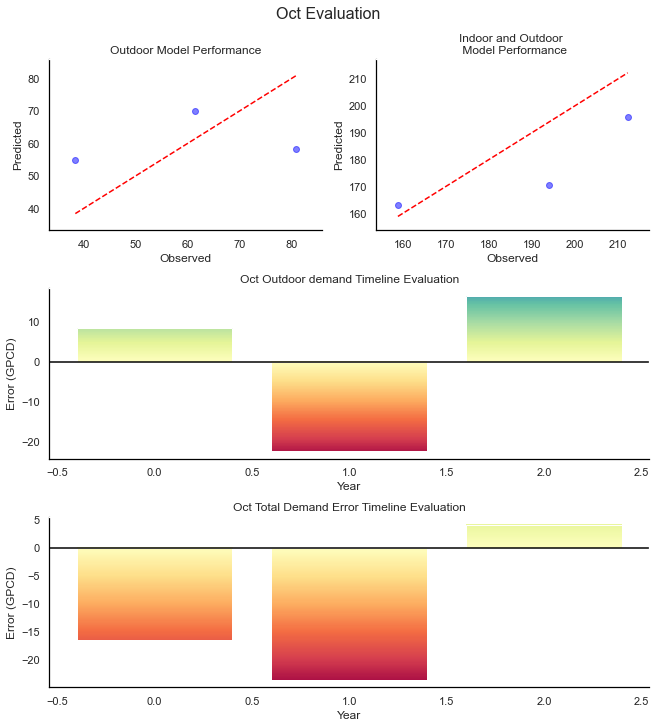

C:\Users\Ryan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


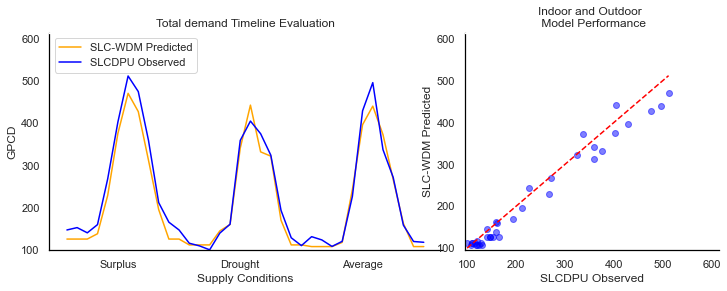

In [13]:
#Separate indoor and outdoor prediction months
Outdoor_Months=['Apr', 'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
IndoorMonths = ['Jan', 'Feb', 'Mar', 'Nov', 'Dec']



slc_val=copy.deepcopy(slc_test)
# calibrate and predict with the outdoor model
pbar = ProgressBar()
for i in pbar(Outdoor_Months):
    
    PerfDF  = MLP_OutdoorDemandModel(slc_train[i],slc_test[i], i, 'ReluDem_{val_loss:.8f}.h5')
    
    colrem = slc_test[i].columns
    slc_val[i] = slc_val[i].reset_index(drop=True)
    slc_val[i] = pd.concat([slc_val[i], PerfDF], axis=1, join="inner")
    slc_val[i] = slc_val[i].set_index('Date')
    slc_val[i] = slc_val[i].drop(columns=colrem)

#Calibrate and predict with the indoor model
for i in IndoorMonths:
    slc_val = Indoor_Demand_Model(slc_val, i)


#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'Seasonal_term_pred_gpcd', 'SLC-WDM')

In [ ]:
#save predictions
np.save('MLP_Models/Slc_Pred.npy', slc_val)

In [14]:
slc_val = np.load('MLP_Models/Slc_Pred.npy', allow_pickle =True).item()

yes
Total R2 is  0.9590024871295585
Total MAE is  20.72183314673465
Total RMSE is  25.88379917103648
Total MAPE is  8.958201208413598


<ipython-input-16-a83d24a1b2ca>:104: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


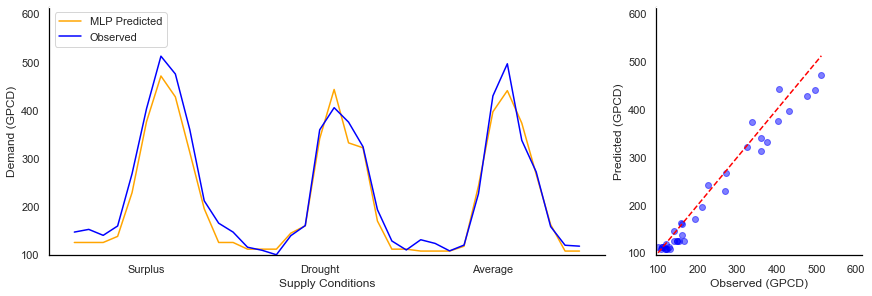

In [18]:
#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', '_Seasonal_term_pred_gpcd', 'MLP ')

In [18]:
from pandas.tseries.offsets import MonthEnd
cols = ['y_test_tot', 'y_pred_tot']
monthorder = ['Jan', 'Feb' , 'Mar', 'Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Pred_Obs = Pred_Obs[cols]

#input population into DF to calculate total water demands.
Population = []
UR_gpcd = []
slc_pred = copy.deepcopy(slc)
for i in monthorder:
    slc_train[i] = copy.deepcopy(slc[i].loc[:2010])
    slc_pred[i] = slc_pred[i].loc[2015:]
    slc_pred[i]['UR_gpcd'] = np.mean(slc_train[i]['Obs_gpcd'])
    Population.append(np.round(slc_pred[i]['Population'],0))
    
UR=pd.DataFrame()
for i in slc_pred:
    slc_pred[i]= pd.DataFrame(slc_pred[i]['UR_gpcd'])
    slc_pred[i]=slc_pred[i].reset_index()
    slc_pred[i]['M'] = datetime.datetime.strptime(i, "%b").month
    slc_pred[i]['D'] = 1
    slc_pred[i]['Date'] = pd.to_datetime(slc_pred[i].Year*10000+slc_pred[i].M*100+slc_pred[i].D,format='%Y%m%d')+MonthEnd(1)
    slc_pred[i].index = slc_pred[i].Date
    slc_pred[i]=slc_pred[i].drop(columns = ['M', 'D', 'Date', 'Year'])
    UR = UR.append(slc_pred[i])

UR=UR.sort_index()
Population = np.sort(np.array(Population).reshape(36,))

#place in to prediction df
Pred_Obs['Population'] = Population
Pred_Obs['UR_gpcd'] = UR['UR_gpcd']



#Now we can form some acre-feet predictions.
gpcd=['y_test_tot','y_pred_tot','UR_gpcd']
for i in gpcd:
    Pred_Obs[i+str('_AF')] = Pred_Obs[i]*Pred_Obs['Population']*9.33454e-5

    
remcol=['y_test_tot','y_pred_tot','UR_gpcd', 'Population']
Ann_Eval = Pred_Obs.drop(columns = remcol).copy()
Ann_Eval = Ann_Eval.resample('Y').sum()



In [1]:
Pred_AF = Demand_Forecast(slc_val, False, Pred_Obs, 
            'y_pred_tot_AF', 'y_test_tot_AF', 'Acre-Feet', 'MLP_Seasonal_pred_AF', 'MLP')

NameError: name 'Demand_Forecast' is not defined

no
Total R2 is  0.6283371213177069
Total MAE is  63.03597863247863
Total RMSE is  77.93344228795345
Total MAPE is  30.78863740465362


<ipython-input-12-a010c38583fc>:104: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


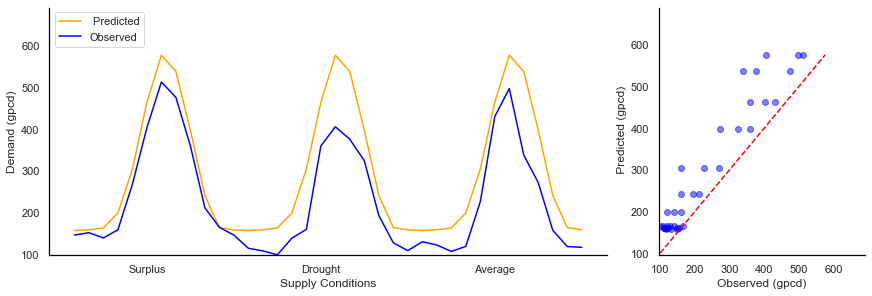

In [20]:
Pred_UR_GPCD = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd',
                'y_test_tot', 'gpcd', 'UR_Seasonal_pred__gpcd', ' ')

In [24]:
Pred_UR_GPCD['StationaryError'] = ((Pred_UR_GPCD['UR_gpcd']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['MLPError'] = ((Pred_UR_GPCD['y_pred_tot']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['StationaryErrorAF'] = Pred_UR_GPCD['UR_gpcd_AF']-Pred_UR_GPCD['y_test_tot_AF']
Pred_UR_GPCD['MLPErrorAF'] = Pred_UR_GPCD['y_pred_tot_AF']-Pred_UR_GPCD['y_test_tot_AF']
Evalcol = ['y_test_tot_AF', 'y_pred_tot_AF', 'StationaryError','MLPError', 'StationaryErrorAF', 'MLPErrorAF']
Eval = Pred_UR_GPCD[Evalcol]

Annual = Eval.resample('Y').sum()
Annual['S_Perror'] = Annual['StationaryErrorAF']/Annual['y_test_tot_AF']*100
Annual['MLP_Perror'] = Annual['MLPErrorAF']/Annual['y_test_tot_AF']*100
Annual

,y_test_tot_AF,y_pred_tot_AF,StationaryError,MLPError,StationaryErrorAF,MLPErrorAF,S_Perror,MLP_Perror
Date,,,,,,,,
2015-12-31,100550.276769,88885.303742,139.858017,-155.307626,12207.162705,-11664.973027,12.140357,-11.601135
2016-12-31,81646.774954,80032.105575,512.522236,-18.067616,32430.298904,-1614.669379,39.720245,-1.977628
2017-12-31,86505.457871,83166.319007,455.384862,-52.171378,28891.579705,-3339.138863,33.398563,-3.860033


In [25]:
Eval

,y_test_tot_AF,y_pred_tot_AF,StationaryError,MLPError,StationaryErrorAF,MLPErrorAF
Date,,,,,,
2015-01-31,4709.274282,4020.242564,7.342278,-14.631378,345.767994,-689.031718
2015-02-28,4888.568674,4020.242564,4.579880,-17.762379,223.890584,-868.326110
2015-03-31,4493.545735,4020.242564,16.816118,-10.532955,755.639941,-473.303171
2015-04-30,5114.524352,4424.462629,24.996996,-13.492197,1278.477435,-690.061723
2015-05-31,8583.758986,7329.383576,13.335806,-14.613358,1144.713444,-1254.375410
2015-06-30,12890.020382,12029.729591,14.946044,-6.674084,1926.548117,-860.290792
2015-07-31,16379.389681,15065.430252,12.453508,-8.022029,2039.808677,-1313.959429
2015-08-31,15197.197243,13680.049464,13.006844,-9.983076,1976.675810,-1517.147779
2015-09-30,11502.006931,9997.498678,10.339270,-13.080398,1189.223590,-1504.508254


no
Total R2 is  0.6235333383547133
Total MAE is  2043.3946037944281
Total RMSE is  2529.7467407378826
Total MAPE is  30.788637404653628


<ipython-input-12-a010c38583fc>:104: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


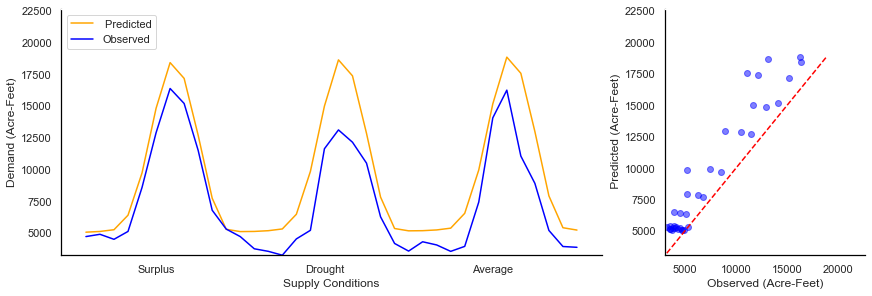

In [21]:
Pred_UR_AF = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd_AF', 
                             'y_test_tot_AF', 'Acre-Feet', 'UR_Seasonal_pred_UR_AF', ' ')

In [40]:
'''I am putting a hard code on the limits here to make both figure have same color scale'''

plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars, ymin, ymax):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
 #   ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral_r')
    ax.axis([xmin, xmax, ymin, ymax])


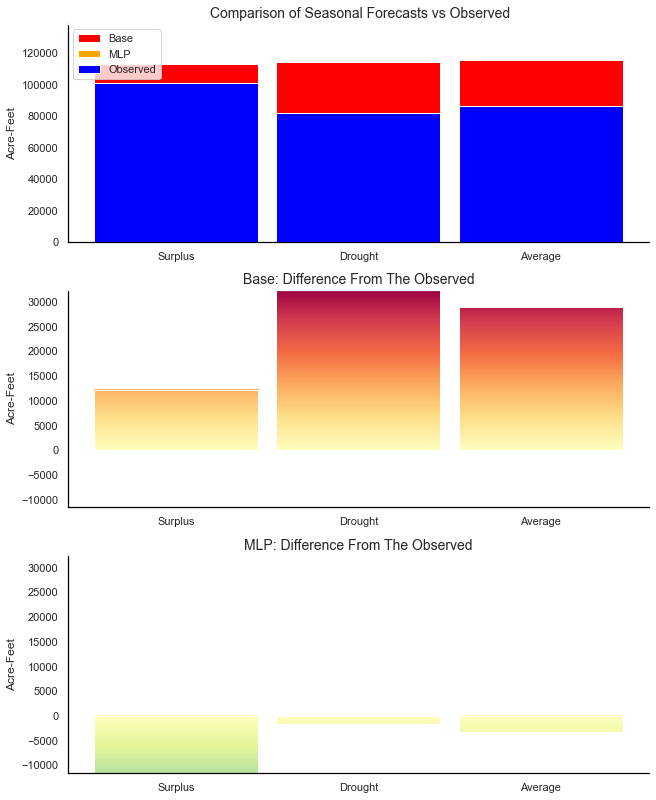

In [44]:
#Reduce width to increase space between bars
width = .9
widthM = 1
titlesize = 14

Ann_Eval['Supply'] = ['Surplus', 'Drought', 'Average']
Ann_Eval.index = Ann_Eval['Supply']

DayDF = Ann_Eval

fig, ax = plt.subplots(3,1, constrained_layout=True)
fig.set_size_inches(9,11)
DayDF['Error_SLC_WDM'] = DayDF.y_pred_tot_AF-DayDF.y_test_tot_AF
DayDF['Error_UR'] = DayDF.UR_gpcd_AF-DayDF.y_test_tot_AF

#save this df to load into MLR file for comparision figure
DayDF.to_excel('MLP_Models/MLP_Ann_Comp.xlsx')


#Annual Figure

ax[0].bar(DayDF.Supply, DayDF.UR_gpcd_AF, width=width, 
    color='red', label='Base')
ax[0].bar(DayDF.Supply, DayDF.y_pred_tot_AF, width=width, 
    color='orange', label='MLP')
ax[0].bar(DayDF.Supply, DayDF.y_test_tot_AF, width=width, 
    color='blue', label='Observed')
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Acre-Feet')
ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')


Error_UR = ax[1].bar(DayDF.index, DayDF.Error_UR, width=width, 
    color='red', label='Base')
ax[1].set_ylabel('Acre-Feet')
ax[1].set_title('Base: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_UR, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')



Error_SLC_WDM = ax[2].bar(DayDF.Supply, DayDF.Error_SLC_WDM, width=width, 
    color='red', label='Base')
ax[2].set_ylabel('Acre-Feet')
ax[2].set_title('MLP: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_SLC_WDM, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')

fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/SLC_WDM_MLPvsUR.pdf')

,y_test_tot_AF,y_pred_tot_AF,UR_gpcd_AF,Supply,Error_SLC_WDM,Error_UR
Supply,,,,,,
Surplus,100550.276769,88885.303742,112757.439473,Surplus,-11664.973027,12207.162705
Drought,81646.774954,80032.105575,114077.073858,Drought,-1614.669379,32430.298904
Average,86505.457871,83166.319007,115397.037575,Average,-3339.138863,28891.579705
